# LFW Dataset facenet pretrained model evaluation

### Step 1, load pretrained model and dataset

In [1]:
%%capture
import tensorflow as tf
import os
from models import inception_resnet_v1
from utils import load_imgdir, infer_imgs, Detector
import numpy as np

# Setup model.
model = inception_resnet_v1
image_batch = tf.placeholder(tf.uint8, shape=[None, 160, 160, 3], name='images')
image = (tf.to_float(image_batch) - 127.5) / 128.0
prelogits, _ = model.inference(image, 1.0, False, bottleneck_layer_size=512)
embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10, name='embeddings')

# Load frozen mdoel weights.
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, 
              "/tf/FaceAdvTransfer/models/facenetLFW/model-20180402-114759.ckpt-275")

In [2]:
victim_imgdir = "/tf/FaceAdvTransfer/source_imgs"
target_imgdir = "/tf/LFW/lfw_mtcnnpy_160/Arnold_Schwarzenegger"
victim_imgs = load_imgdir(victim_imgdir)
target_imgs = load_imgdir(target_imgdir)

In [3]:
model_in = image_batch
model_out = embeddings
def model_infer_func(input_):
    prelogits, _ = model.inference(input_, 1.0, False, bottleneck_layer_size=512)
    embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10)
    
    return embeddings

### Step 2, compute embeddings of target images

In [4]:
target_embeddings = infer_imgs(target_imgs, sess,
                               model_in, model_out, 
                               batch_size=16)

### Step 3, detect faces in victim images

In [5]:
detector = Detector()
bouding_boxes = []
cropped_victim_faces = []

for victim in victim_imgs:
    scaled_face, bbox = detector.detect(victim)
    bouding_boxes.append(bbox)
    cropped_victim_faces.append(scaled_face)

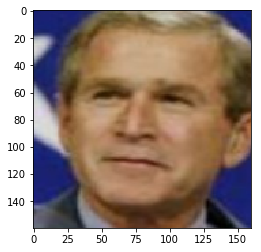

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#plt.subplot(121)
plt.imshow(cropped_victim_faces[0])
#plt.subplot(122)
#plt.imshow(cropped_victim_faces[1])

### Step 4, perform modified pgd attack

In [7]:
from attack.pgd import pgd_attack

# Build up adv attack workflow.
adv_face = pgd_attack(model_in, model_infer_func, target_embeddings)

adv_faces = infer_imgs(cropped_victim_faces, sess, 
                       model_in, adv_face, 
                       batch_size=16)

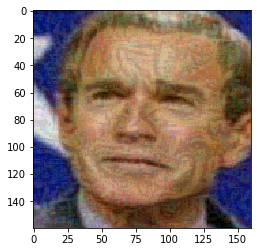

In [8]:
%matplotlib inline
plt.imshow(adv_faces[0].astype(np.int))

### Step 5, put cropped image back to original image

In [9]:
%%capture
from scipy import misc

adv_victims = np.copy(victim_imgs)
for victim, bbox, adv_face in zip(adv_victims, bouding_boxes, adv_faces):
    adv_face_rescaled = misc.imresize(adv_face,
                                     (bbox[3] - bbox[1], bbox[2] - bbox[0]))
    victim[bbox[1]:bbox[3], bbox[0]:bbox[2], :] = adv_face_rescaled

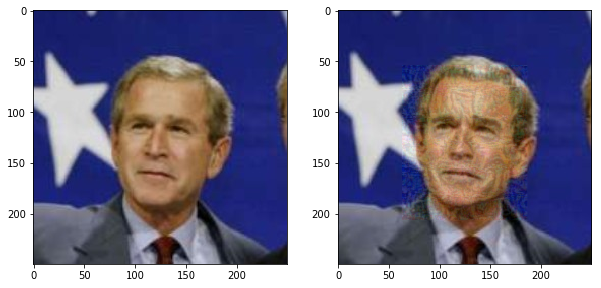

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(victim_imgs[0])
plt.subplot(122)
plt.imshow(adv_victims[0])

In [11]:
import cv2

cv2.imwrite('./attack_results/Bush.png', adv_victims[0][:, :, ::-1])

True

### Step 6, test on local network.

As we can see in the result, the normal prediction of George Bush was changed to Arnold Schwarzenegger.

In [4]:
%%bash
export PYTHONPATH=/tf/FaceAdvTransfer/facenet/src
#cd /tf/FaceAdvTransfer/facenet/src
python /tf/FaceAdvTransfer/facenet/contributed/predict.py \
/tf/FaceAdvTransfer/attack_results/Bush.png \
/tf/FaceAdvTransfer/models/facenetLFW/20180402-114759.pb \
/tf/FaceAdvTransfer/models/facenetLFW/lfw_SVM_classifier.pkl \
--gpu_memory_fraction 0.5

Creating networks and loading parameters
Model filename: /tf/FaceAdvTransfer/models/facenetLFW/20180402-114759.pb
Loaded classifier model from file "/tf/FaceAdvTransfer/models/facenetLFW/lfw_SVM_classifier.pkl"


people in image /tf/FaceAdvTransfer/attack_results/Bush.png :
Arnold Schwarzenegger: 0.786


2019-04-10 06:21:31.953933: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-04-10 06:21:32.039610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-10 06:21:32.040012: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5055430 executing computations on platform CUDA. Devices:
2019-04-10 06:21:32.040027: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): GeForce GTX 1060 6GB, Compute Capability 6.1
2019-04-10 06:21:32.041404: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3192285000 Hz
2019-04-10 06:21:32.042322: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x50c0240 executing computations on platform Host. Devices:
2019-04-10 06:21:32.042335: I tensorflo

In [2]:
%%bash
export PYTHONPATH=/tf/FaceAdvTransfer/facenet/src
#/tf/FaceAdvTransfer/t01ca956c6de7fabb3d.jpg
#/tf/FaceAdvTransfer/source_imgs/745973-72980417f886d0f6.jpeg
#cd /tf/FaceAdvTransfer/facenet/src
python /tf/FaceAdvTransfer/facenet/contributed/predict.py \
/tf/FaceAdvTransfer/source_imgs/George_W_Bush_0001.jpg \
/tf/FaceAdvTransfer/models/facenetLFW/20180402-114759.pb \
/tf/FaceAdvTransfer/models/facenetLFW/lfw_SVM_classifier.pkl \
--gpu_memory_fraction 0.5

Creating networks and loading parameters
Model filename: /tf/FaceAdvTransfer/models/facenetLFW/20180402-114759.pb
Loaded classifier model from file "/tf/FaceAdvTransfer/models/facenetLFW/lfw_SVM_classifier.pkl"


people in image /tf/FaceAdvTransfer/source_imgs/George_W_Bush_0001.jpg :
George W Bush: 0.838


2019-04-10 06:18:19.060475: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-04-10 06:18:19.139116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-04-10 06:18:19.139603: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5cea240 executing computations on platform CUDA. Devices:
2019-04-10 06:18:19.139617: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): GeForce GTX 1060 6GB, Compute Capability 6.1
2019-04-10 06:18:19.141978: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3192285000 Hz
2019-04-10 06:18:19.144537: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5d55050 executing computations on platform Host. Devices:
2019-04-10 06:18:19.144556: I tensorflo

### Step 7, test on other image recognition system

This is a work reproduced on attacking AWS recognition system, so we will try it here first.

In [3]:
import logging, sys
logging.disable(sys.maxsize)

### The following cell should be ran first to generate SVM classifier if itu's the first time running facenet.

In [ ]:
%%bash
cd /tf/FaceAdvTransfer/facenet/src
# train SVM classifier first
python classifier.py TRAIN \
/tf/LFW/lfw_mtcnnpy_160/ \
/tf/FaceAdvTransfer/models/facenetLFW/20180402-114759.pb \
/tf/FaceAdvTransfer/models/facenetLFW/lfw_SVM_classifier.pkl \
--batch_size 1000 --min_nrof_images_per_class 40 \
--nrof_train_images_per_class 35 --use_split_dataset